<a href="https://colab.research.google.com/github/Masterjun12/Pytorch-tutorials-/blob/main/autogradqs_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[파이토치(PyTorch) 기본 익히기](intro.html) ||
[빠른 시작](quickstart_tutorial.html) ||
[텐서(Tensor)](tensorqs_tutorial.html) ||
[Dataset과 Dataloader](data_tutorial.html) ||
[변형(Transform)](transforms_tutorial.html) ||
[신경망 모델 구성하기](buildmodel_tutorial.html) ||
**Autograd** ||
[최적화(Optimization)](optimization_tutorial.html) ||
[모델 저장하고 불러오기](saveloadrun_tutorial.html)

# ``torch.autograd``\ 를 사용한 자동 미분

신경망을 학습할 때 가장 자주 사용되는 알고리즘은 **역전파**\ 입니다. 이 알고리즘에서,
매개변수(모델 가중치)는 주어진 매개변수에 대한 손실 함수의 **변화도(gradient)**\ 에
따라 조정됩니다.

이러한 변화도를 계산하기 위해 PyTorch에는 ``torch.autograd``\ 라고 불리는 자동 미분 엔진이
내장되어 있습니다. 이는 모든 계산 그래프에 대한 변화도의 자동 계산을 지원합니다.

입력 ``x``, 매개변수 ``w``\ 와 ``b`` , 그리고 일부 손실 함수가 있는 가장 간단한 단일 계층
신경망을 가정하겠습니다. PyTorch에서는 다음과 같이 정의할 수 있습니다:


In [ ]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## Tensor, Function과 연산그래프(Computational graph)

이 코드는 다음의 **연산 그래프** 를 정의합니다:

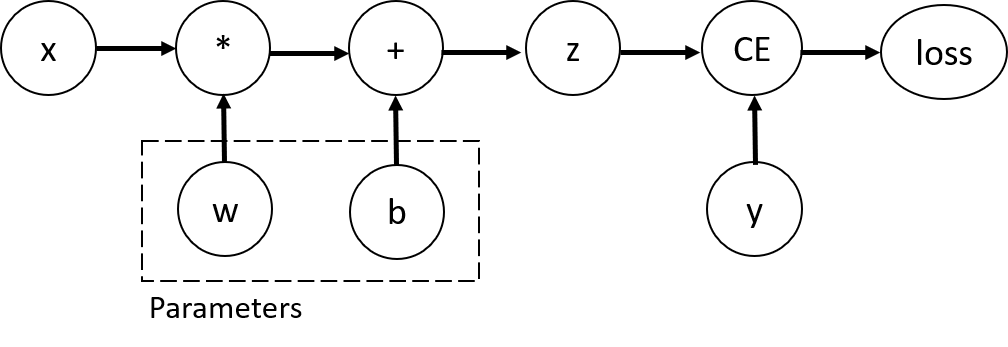.. figure:: /_static/img/basics/comp-graph.png
   :alt:

이 신경망에서, ``w``\ 와 ``b``\ 는 최적화를 해야 하는 **매개변수**\ 입니다. 따라서
이러한 변수들에 대한 손실 함수의 변화도를 계산할 수 있어야 합니다. 이를 위해서 해당 텐서에
``requires_grad`` 속성을 설정합니다.



<div class="alert alert-info"><h4>Note</h4><p>``requires_grad``\ 의 값은 텐서를 생성할 때 설정하거나, 나중에
          ``x.requires_grad_(True)`` 메소드를 사용하여 나중에 설정할 수도 있습니다.</p></div>



연산 그래프를 구성하기 위해 텐서에 적용하는 함수는 사실 ``Function`` 클래스의 객체입니다.
이 객체는 *순전파* 방향으로 함수를 계산하는 방법과, *역방향 전파* 단계에서 도함수(derivative)를
계산하는 방법을 알고 있습니다. 역방향 전파 함수에 대한 참조(reference)는 텐서의 ``grad_fn``
속성에 저장됩니다. ``Function``\ 에 대한 자세한 정보는
[이 문서](https://pytorch.org/docs/stable/autograd.html#function)_
에서 찾아볼 수 있습니다.




In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7afeae426620>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7afeae4263e0>


## 변화도(Gradient) 계산하기

신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수(derivative)를
계산해야 합니다. 즉, ``x``\ 와 ``y``\ 의 일부 고정값에서 $\frac{\partial loss}{\partial w}$\ 와
$\frac{\partial loss}{\partial b}$ 가 필요합니다.
이러한 도함수를 계산하기 위해, ``loss.backward()`` 를 호출한 다음 ``w.grad``\ 와
``b.grad``\ 에서 값을 가져옵니다:




In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0102, 0.1789, 0.0111],
        [0.0102, 0.1789, 0.0111],
        [0.0102, 0.1789, 0.0111],
        [0.0102, 0.1789, 0.0111],
        [0.0102, 0.1789, 0.0111]])
tensor([0.0102, 0.1789, 0.0111])


<div class="alert alert-info"><h4>Note</h4><p>- 연산 그래프의 잎(leaf) 노드들 중 ``requires_grad`` 속성이 ``True``\ 로 설정된
    노드들의 ``grad`` 속성만 구할 수 있습니다. 그래프의 다른 모든 노드에서는 변화도가
    유효하지 않습니다.
  - 성능 상의 이유로, 주어진 그래프에서의 ``backward``\ 를 사용한 변화도 계산은 한 번만
    수행할 수 있습니다. 만약 동일한 그래프에서 여러번의 ``backward`` 호출이 필요하면,
    ``backward`` 호출 시에 ``retrain_graph=True``\ 를 전달해야 합니다.</p></div>




## 변화도 추적 멈추기

기본적으로, ``requires_grad=True``\ 인 모든 텐서들은 연산 기록을 추적하고 변화도 계산을
지원합니다. 그러나 모델을 학습한 뒤 입력 데이터를 단순히 적용하기만 하는 경우와 같이 *순전파*
연산만 필요한 경우에는, 이러한 추적이나 지원이 필요 없을 수 있습니다.
연산 코드를 ``torch.no_grad()`` 블록으로 둘러싸서 연산 추적을 멈출 수 있습니다:




In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


동일한 결과를 얻는 다른 방법은 텐서에 ``detach()`` 메소드를 사용하는 것입니다:




In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


In [ ]:
z_det

tensor([-3.4603,  0.1466, -3.3703])

변화도 추적을 멈춰야 하는 이유들은 다음과 같습니다:
  - 신경망의 일부 매개변수를 **고정된 매개변수(frozen parameter)**\ 로 표시합니다.
  - 변화도를 추적하지 않는 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 때
    **연산 속도가 향상됩니다.**



## 연산 그래프에 대한 추가 정보

개념적으로, autograd는 데이터(텐서)의 및 실행된 모든 연산들(및 연산 결과가 새로운 텐서인 경우도 포함하여)의
기록을 [Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)_ 객체로
구성된 방향성 비순환 그래프(DAG; Directed Acyclic Graph)에 저장(keep)합니다.
이 방향성 비순환 그래프(DAG)의 잎(leave)은 입력 텐서이고, 뿌리(root)는 결과 텐서입니다.
이 그래프를 뿌리에서부터 잎까지 추적하면 연쇄 법칙(chain rule)에 따라 변화도를 자동으로 계산할 수 있습니다.

순전파 단계에서, autograd는 다음 두 가지 작업을 동시에 수행합니다:

- 요청된 연산을 수행하여 결과 텐서를 계산하고,
- DAG에 연산의 *변화도 기능(gradient function)* 를 유지(maintain)합니다.

역전파 단계는 DAG 뿌리(root)에서 ``.backward()`` 가 호출될 때 시작됩니다. ``autograd``\ 는 이 때:

- 각 ``.grad_fn`` 으로부터 변화도를 계산하고,
- 각 텐서의 ``.grad`` 속성에 계산 결과를 쌓고(accumulate),
- 연쇄 법칙을 사용하여, 모든 잎(leaf) 텐서들까지 전파(propagate)합니다.

<div class="alert alert-info"><h4>Note</h4><p>**PyTorch에서 DAG들은 동적(dynamic)입니다.**
  주목해야 할 중요한 점은 그래프가 처음부터(from scratch) 다시 생성된다는 것입니다; 매번 ``.bachward()`` 가
  호출되고 나면, autograd는 새로운 그래프를 채우기(populate) 시작합니다. 이러한 점 덕분에 모델에서
  흐름 제어(control flow) 구문들을 사용할 수 있게 되는 것입니다; 매번 반복(iteration)할 때마다 필요하면
  모양(shape)이나 크기(size), 연산(operation)을 바꿀 수 있습니다.</p></div>



## 선택적으로 읽기(Optional Reading): 텐서 변화도와 야코비안 곱 (Jacobian Product)

대부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련한 변화도를 계산해야 합니다.
그러나 출력 함수가 임의의 텐서인 경우가 있습니다. 이럴 때, PyTorch는 실제 변화도가 아닌
**야코비안 곱(Jacobian product)**\ 을 계산합니다.

$\vec{x}=\langle x_1,\dots,x_n\rangle$\ 이고,
$\vec{y}=\langle y_1,\dots,y_m\rangle$\ 일 때
벡터 함수 $\vec{y}=f(\vec{x})$\ 에서 $\vec{x}$\ 에 대한
$\vec{y}$ 의 변화도는 **야코비안 행렬(Jacobian matrix)**\ 로 주어집니다:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

야코비안 행렬 자체를 계산하는 대신, PyTorch는 주어진 입력 벡터 $v=(v_1 \dots v_m)$\ 에 대한
**야코비안 곱(Jacobian Product)**  $v^T\cdot J$\ 을 계산합니다.
이 과정은 $v$\ 를 인자로 ``backward``\ 를 호출하면 이뤄집니다. $v$\ 의 크기는
곱(product)을 계산하려고 하는 원래 텐서의 크기와 같아야 합니다.




In [ ]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


동일한 인자로 ``backward``\ 를 두차례 호출하면 변화도 값이 달라집니다.
이는 ``역방향`` 전파를 수행할 때, PyTorch가 **변화도를 누적(accumulate)해주기 때문**\
입니다. 즉, 계산된 변화도의 값이 연산 그래프의 모든 잎(leaf) 노드의 ``grad`` 속성에
추가됩니다. 따라서 제대로 된 변화도를 계산하기 위해서는 ``grad`` 속성을 먼저 0으로 만들어야
합니다. 실제 학습 과정에서는 *옵티마이저(optimizer)*\ 가 이 과정을 도와줍니다.



<div class="alert alert-info"><h4>Note</h4><p>이전에는 매개변수 없이 ``backward()`` 함수를 호출했습니다. 이는 본질적으로
          ``backward(torch.tensor(1.0))`` 을 호출하는 것과 동일하며,
          신경망 훈련 중의 손실과 같은 스칼라-값 함수의 변화도를 계산하는 유용한 방법입니다.</p></div>




--------------




### 더 읽어 보기
- [Autograd Mechanics](https://pytorch.org/docs/stable/notes/autograd.html)

